In [124]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline


In [ ]:

import pandas as pd


df_ibm = pd.read_csv('ibm_data/1.csv')


print(df_ibm.shape) 
X = df_ibm.values.reshape(-1, 6) 


X = X[X.shape[0] // 2:]
print(X.shape)
print(X[:5]) 
X[:, 0::2] = X[:, 0::2] - 1204  # even columns: 1202
X[:, 1::2] = X[:, 1::2] - 1221  # odd columns: 1221
print(X[:5])

# Swap odd and even columns in X
X = X[:, np.array([1, 0, 3, 2, 5, 4])]
print(X[:5])
# Change the sign for y columns (odd indices: 1, 3, 5)
X[:, 1::2] = -X[:, 1::2]
print(X[:5])

(17949, 6)
(8975, 6)
[[1173 1225 1418  676 1867  576]
 [1173 1225 1429  681 1873  557]
 [1173 1225 1441  687 1876  537]
 [1173 1225 1453  693 1878  518]
 [1173 1225 1465  700 1879  500]]
[[ -31    4  214 -545  663 -645]
 [ -31    4  225 -540  669 -664]
 [ -31    4  237 -534  672 -684]
 [ -31    4  249 -528  674 -703]
 [ -31    4  261 -521  675 -721]]
[[   4  -31 -545  214 -645  663]
 [   4  -31 -540  225 -664  669]
 [   4  -31 -534  237 -684  672]
 [   4  -31 -528  249 -703  674]
 [   4  -31 -521  261 -721  675]]
[[   4   31 -545 -214 -645 -663]
 [   4   31 -540 -225 -664 -669]
 [   4   31 -534 -237 -684 -672]
 [   4   31 -528 -249 -703 -674]
 [   4   31 -521 -261 -721 -675]]


In [ ]:

train_time  = 50.

test_time   = 30.

warm_time   = 50.



total_samples = X.shape[0]
print("Total samples:", total_samples)

begin = 2000
end = 5000
trimmed_size = end - begin


train_steps = round(train_time * trimmed_size / (train_time + test_time + warm_time))
test_steps  = round(test_time  * trimmed_size / (train_time + test_time + warm_time))
warm_steps  = round(warm_time  * trimmed_size / (train_time + test_time + warm_time))

print("train_steps:", train_steps)
print("test_steps:", test_steps)
print("warm_steps:", warm_steps)

X = X[begin: begin + train_steps + test_steps + warm_steps, -4:]


print("X shape:", X.shape)

Total samples: 8975
train_steps: 1154
test_steps: 692
warm_steps: 1154
X shape: (3000, 4)


-6.047889583612906 5.793954452053598
-5706.2671138843325 11392.882917342251
-3.4074015600642347 3.239312070547746
-8.001874330739593 15.96797070959725


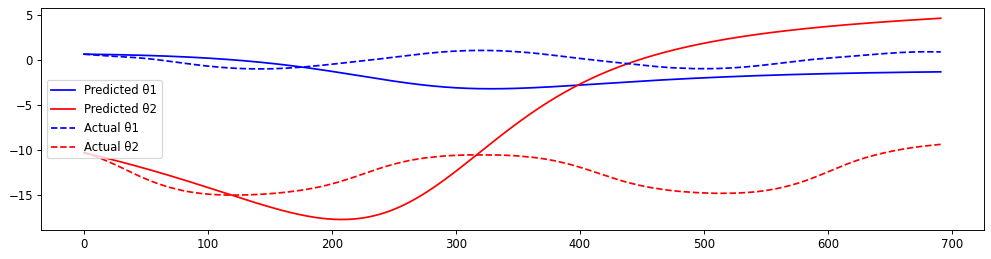

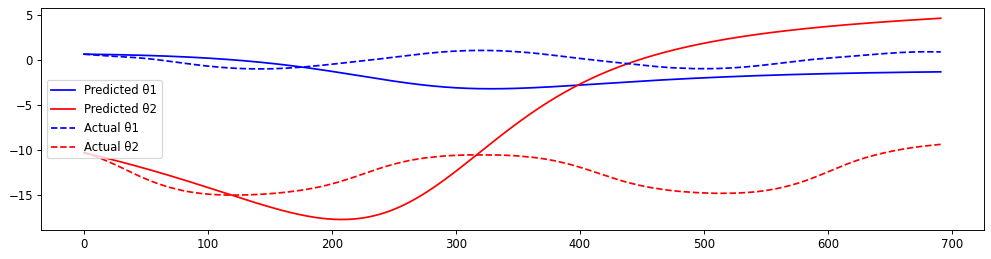

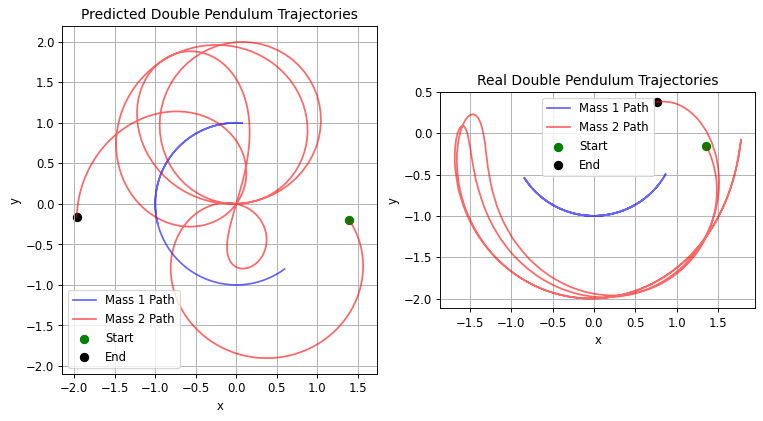

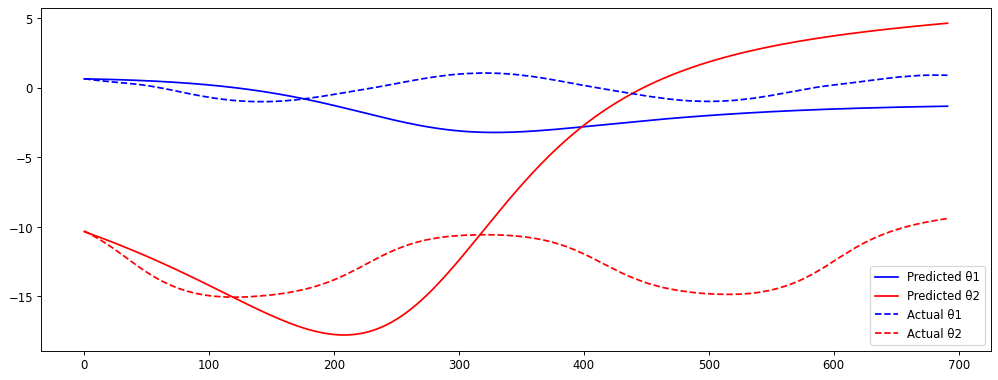

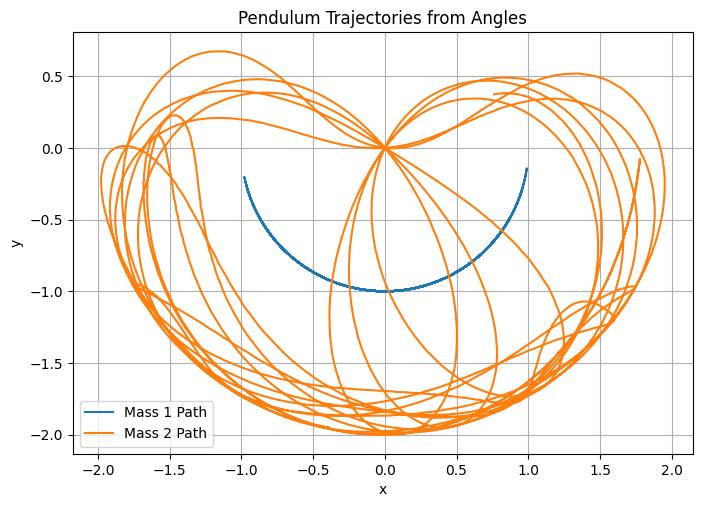

Training data shape: (3000, 4)
First 5 rows of training data:
 [[ -0.31123628  -0.08061096   2.99760139 -13.17959161]
 [ -0.3333715   -0.12193043   3.00147022 -11.29359511]
 [ -0.35385469  -0.17051343  -0.55009635   3.00608326]
 [ -0.37433362  -0.21701761  -2.6569539    6.83579285]
 [ -0.39707945  -0.25710248   1.51592895  -4.43969618]]


In [ ]:
from sklearn.preprocessing import StandardScaler

def plot_xy_columns(data):

    n_pairs = data.shape[1] // 2
    plt.figure(figsize=(8, 6))
    for i in range(n_pairs):
        x = data[:, 2*i]
        y = data[:, 2*i+1]
        plt.plot(x, y, label=f'Mass {i+1} Path')
    plt.title("Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()



def xy_to_angles(data, l1=1.0, l2=1.0):
    x1, y1, x2, y2 = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    th1 = np.arctan2(x1, -y1)
    th2 = np.arctan2(x2 - x1, -(y2 - y1))
    return th1, th2

def compute_angular_accelerations(theta1, theta2, dt=0.0166):

    o1 = np.gradient(theta1, dt)
    o2 = np.gradient(theta2, dt)

    alpha1 = np.gradient(o1, dt)
    alpha2 = np.gradient(o2, dt)
    
    return alpha1, alpha2

t1, t2 = xy_to_angles(X, l1=1.0, l2=1)
o1, o2 = compute_angular_accelerations(t1, t2)

print(o1.min(), o1.max())
print(o2.min(), o2.max())

from sklearn.preprocessing import StandardScaler
o1_norm = (o1 - np.mean(o1)) / np.std(o1)
o2_norm = (o2 - np.mean(o2)) / np.std(o2)

print(o1_norm.min(), o1_norm.max())
print(o2_norm.min(), o2_norm.max())



def plot_from_theta(theta1, theta2, l1=1.0, l2=1, label_prefix=""):

    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label=f'{label_prefix}Mass 1 Path')
    plt.plot(x2, y2, label=f'{label_prefix}Mass 2 Path')
    plt.title("Pendulum Trajectories from Angles")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()



plot_from_theta(t1, t2)



th1 = np.unwrap(t1)
th2 = np.unwrap(t2)


scaler = StandardScaler()
o1_norm = scaler.fit_transform(o1.reshape(-1,1)).ravel()
o2_norm = scaler.fit_transform(o2.reshape(-1,1)).ravel()



sin_th1 = np.sin(th1)
cos_th1 = np.cos(th1)
sin_th2 = np.sin(th2)
cos_th2 = np.cos(th2)


training_data_2 = np.stack([th1, th2,o1,o2], axis=1)

print("Training data shape:", training_data_2.shape)
print("First 5 rows of training data:\n", training_data_2[:5])



In [ ]:
from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=2, strides=1)
readout = Ridge(4, ridge=1e-4, input_bias=False)

model = nvar >> readout


Xi  = training_data_2[:train_steps+warm_steps-1]
dXi = (training_data_2[1:train_steps+warm_steps] - training_data_2[:train_steps+warm_steps-1] )


print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

nvar.run(training_data_2[warm_steps+train_steps-2:warm_steps+train_steps])
u = training_data_2[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Xi shape: (2307, 4), dXi shape: (2307, 4)


Running Model-21:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-21: 2307it [00:00, 4205.67it/s]
Running Model-21: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


Fitting node Ridge-21...


Running NVAR-21: 100%|██████████| 2/2 [00:00<00:00, 2697.30it/s]


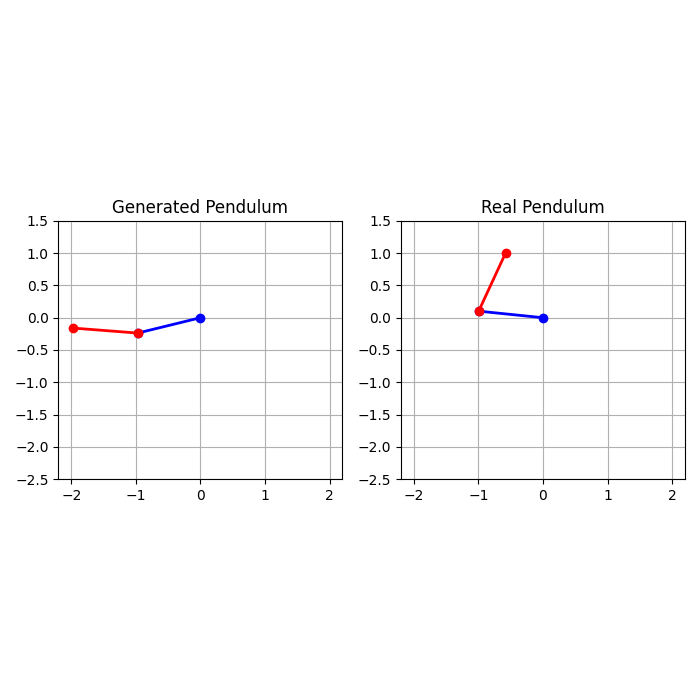

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter


l1, l2 = 1.0, 1.0


N = test_steps
Y = X[warm_steps + train_steps:]


def get_positions(data):
    th1, th2 = data[:, 0], data[:, 1]
    x1 = l1 * np.sin(th1)
    y1 = -l1 * np.cos(th1)
    x2 = x1 + l2 * np.sin(th2)
    y2 = y1 - l2 * np.cos(th2)
    return x1, y1, x2, y2


x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")


gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2


def update(frame):

    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])


    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

FFwriter = FFMpegWriter(fps=10)
ani.save('./pendulum_6.mp4', writer=FFwriter)

plt.tight_layout()
plt.show()


In [130]:
%matplotlib widget
import matplotlib.pyplot as plt

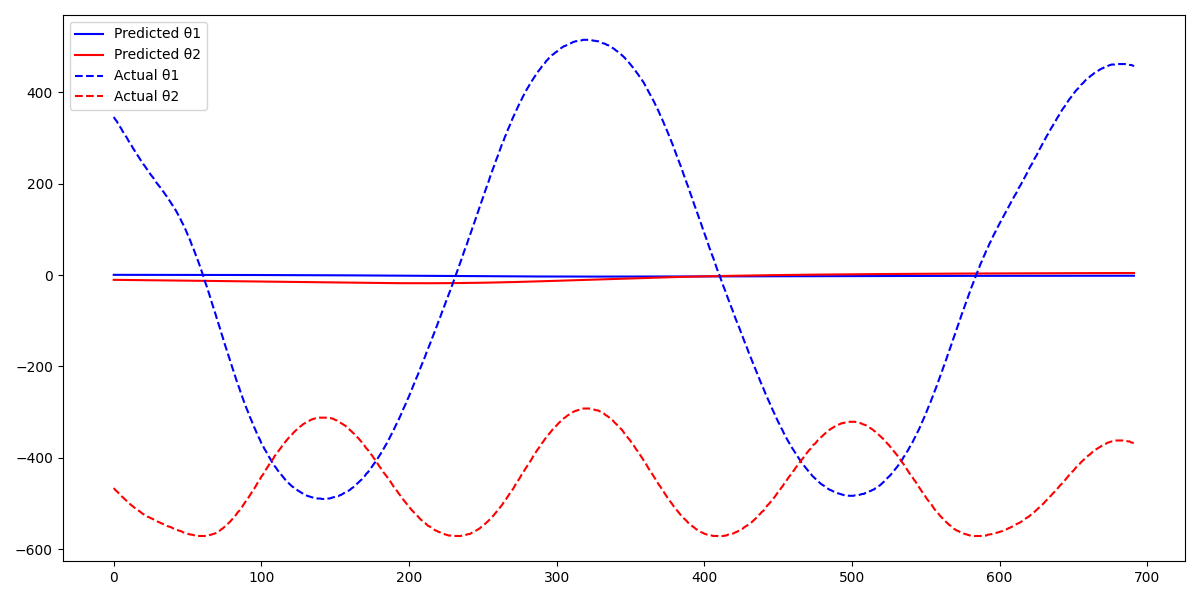

In [ ]:
plt.figure(figsize=(12, 6))


th1_pred = res[:, 0]
th2_pred = res[:, 1]


th1_true = Y[:, 0]
th2_true = Y[:, 1]


plt.subplot(1, 1, 1)
plt.plot(np.arange(N), th1_pred, label='Predicted θ1', color='blue')
plt.plot(np.arange(N), th2_pred, label='Predicted θ2', color='red')
plt.plot(np.arange(N), th1_true, label='Actual θ1', color='blue', linestyle='--')
plt.plot(np.arange(N), th2_true, label='Actual θ2', color='red', linestyle='--')

plt.legend()

plt.tight_layout()
plt.show()